Populating the interactive namespace from numpy and matplotlib
Starting MATLAB on ZMQ socket ipc:///tmp/pymatbridge-5d82d190-9392-43c6-b473-4dce9bfb64bc
Send 'exit' command to kill the server
...........MATLAB started and connected!

/Users/kevm1892/anaconda/lib/python2.7/site-packages/IPython/nbformat.py:13: ShimWarning: The `IPython.nbformat` package has been deprecated. You should import from nbformat instead.
  "You should import from nbformat instead.", ShimWarning)
/Users/kevm1892/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


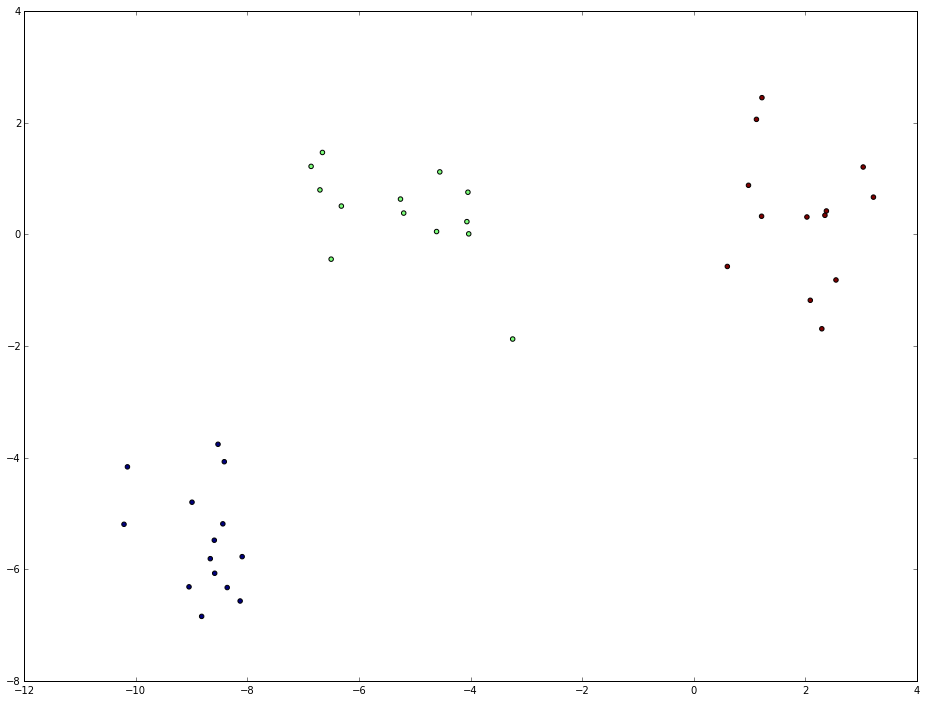

In [1]:
%pylab inline
from sklearn.datasets import make_blobs
import numpy as np
import pandas as pd
pylab.rcParams['figure.figsize'] = 16, 12 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
# Initialize matlab 
import pymatbridge as pymat
ip = get_ipython()
pymat.load_ipython_extension(ip, matlab='/Applications/MATLAB_R2013a_Student.app/bin/matlab')
n_samples = 40
random_state = 170
x, y = make_blobs(n_samples=n_samples, random_state=random_state)


clf = KMeans(3)
ypred = clf.fit_predict(x)
clf.cluster_centers_
centers_dict = {i:cc for i,cc in enumerate(clf.cluster_centers_)}
scatter(x[:,0],x[:,1],c=y)
x=x.T


# Build W matrix
omg = 0.05
N = n_samples
d = 2 
W = asarray([map(lambda pnt:np.exp(-omg*norm(pnt)**2),x.T - \
                 np.repeat(array([x.T[j]]),N,axis=0)) for j in range(N)])



def produce_labels(mu1):
    pnt_map = asarray([map(lambda x: round(x,2),_) for _ in mu1.T])
    df = pd.DataFrame(pnt_map)
    unique_x0_vals = df.iloc[:,0].value_counts().keys().values

    def label_func(x,arr = unique_x0_vals,colors = c):
        for i in range(len(unique_x0_vals)):
            if x[0] == unique_x0_vals[i]:
                return i

    df['label'] = df.apply(label_func ,axis=1)
    labels = df['label'].values
    return labels

# The objective/Weight building function
def obj(x,u,W,lambd):
    cnt = 0
    weight_vect = []
    norm_vect = []
    total = 0 
    N = len(u)
    print N
    # the sum of i<j can be written as
    for j in range(2,N+1):
        for i in range(1,j):
            cnt+=1
            temp = norm(u[i-1,:]-u[j-1,:])
            total+=W[i-1,j-1]*temp
            #total+=1*temp
            norm_vect.append(temp)
            weight_vect.append(W[i-1,j-1])
    total = lambd * total
    print cnt
    print total
    #total = .5 * np.sum(norm(x-u)) +total
    return total,weight_vect,norm_vect

In [2]:
%%matlab -i x,N -o Q
%N = length(x);
d = 2
lambda = 0.3
%lambda = 0
p = 2
eps = 0.05

i=1;
for t=1:N
    for k=t+1:N
     Q(i,t)=1;Q(i,k)=-1;i=i+1;
    end
end



d =

     2


lambda =

    0.3000


p =

     2


eps =

    0.0500



In [3]:
''' An easy way to map the weights the proper order for the Q matrix '''
mu1 = rand(d,N) #dummy variable for objective function
[val,weights,norm_vect] = obj(x.T,mu1.T,W,1.7)
norm_vect3 = [norm(_) for _ in np.dot(Q,mu1.T)]
dict1 = {x:i for i,x in enumerate(norm_vect)}
dict2 = {x:i for i,x in enumerate(norm_vect3)}
dict1 = sorted(dict1.items(),key = lambda x:x[0])
dict2 = sorted(dict2.items(),key = lambda x:x[0])
Wkeys = [_[1] for _ in dict1]
Qkeys = [_[1] for _ in dict2]
W_to_Qmap = {j:i for i,j in zip(Wkeys,Qkeys)}
weights_Q = [weights[W_to_Qmap[i]] for i,w in enumerate(weights)]

40
780
193.121502485


In [152]:
%%matlab -i W,x,N,weights_Q -o mu1,mu2,Q,v1,v2
%N = length(x);
d = 2
lambda = 0.5
p = 2
eps = 0.05
alpha = 0.8

i=1;
for t=1:N
    for k=t+1:N
     Q(i,t)=1;Q(i,k)=-1;i=i+1;
    end
end
g = 0
h = 0

%%%%%%%%%%%%% solve convex cluster formulation %%%%%%%%%%%%%
cvx_begin
variable mu1(d,N)
for i =1:N
    g = g + sum(huber(x(:,i)-mu1(:,i),alpha));
end
h = lambda*dot(weights_Q,norms(Q*mu1',2,p))
g = g+h;
minimize(g)
cvx_end
%%%%% constrained least squares %%%%%%
cvx_begin
variable mu2(d,N)
minimize(sum(sum((x-mu2).*(x-mu2))))
subject to
Q(find(norms(Q*mu1',2,p)<eps),:)*mu2'==0
cvx_end
        
             
             

%%%%%%%%%%%%% solve convex cluster formulation %%%%%%%%%%%%%
cvx_begin
variable v1(d,N)
minimize(sum(sum((x-v1).*(x-v1))) ...
         +lambda*dot(weights_Q,norms(Q*v1',2,p)))
cvx_end
%%%%% constrained least squares %%%%%%
cvx_begin
variable v2(d,N)
minimize(sum(sum((x-v2).*(x-v2))))
subject to
Q(find(norms(Q*v1',2,p)<eps),:)*v2'==0
cvx_end
           


d =

     2


lambda =

    0.5000


p =

     2


eps =

    0.0500


alpha =

    0.8000


g =

     0


h =

     0

 
h =
 
    cvx convex expression (scalar)
 
 
Calling SDPT3 4.0: 3060 variables, 1260 equality constraints
   For improved efficiency, SDPT3 is solving the dual problem.
------------------------------------------------------------

 num. of constraints = 1260
 dim. of sdp    var  = 160,   num. of sdp  blk  = 80
 dim. of socp   var  = 2500,   num. of socp blk  = 860
 dim. of linear var  = 320
*******************************************************************
   SDPT3: Infeasible path-following algorithms
*******************************************************************
 version  predcorr  gam  expon  scale_data
   HKM      1      0.000   1        0    
it pstep dstep pinfeas dinfeas  gap      prim-obj      dual-obj    cputime
-------------------------------------------------------------------
 0|0.000|0.000|4.3e+01|2.9e+01|8.6e+05| 9.810193e+02  0.000000e+00| 0:0:

In [139]:
c = np.random.rand(3,len(v2.T))

array([ 3,  2,  0,  0,  7,  2,  0,  5, 12,  6, 11,  0,  0,  5, 10,  4,  1,
        2,  2,  1,  0,  1,  0,  3, 13,  0,  0,  9,  8,  1,  0,  4,  3,  1,
        1,  1,  0,  0,  0,  0])

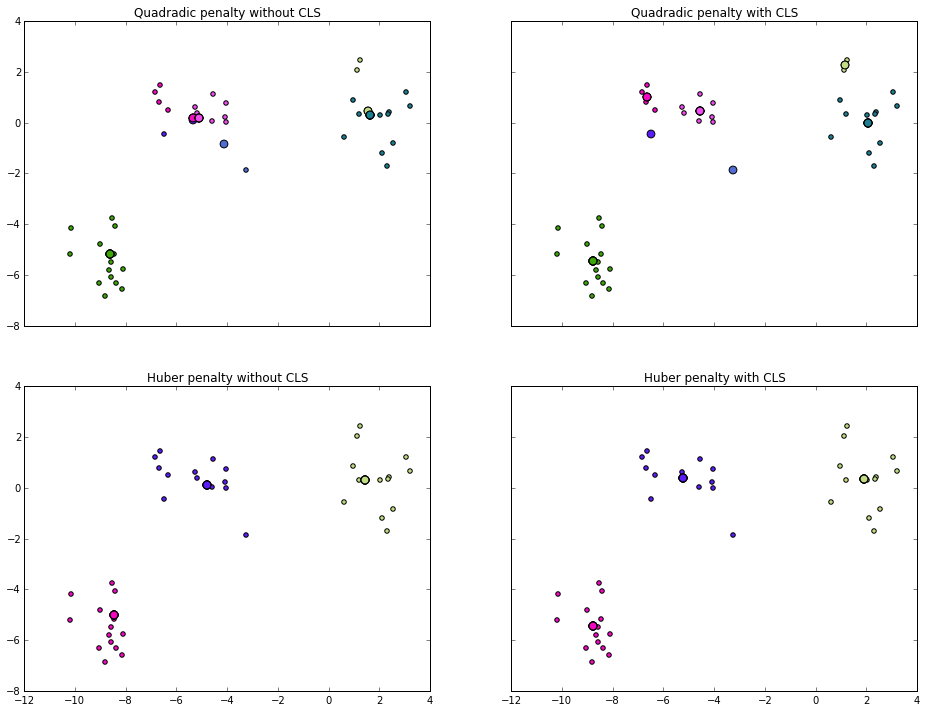

In [153]:
# row and column sharing
import matplotlib.pyplot as plt
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
labels = produce_labels(mu1)
col_os = 3
for i in range(len(x.T)):
    ax3.scatter(x[0,i], x[1,i],c=c[:,col_os+labels[i]])
    ax4.scatter(x[0,i], x[1,i],c=c[:,col_os+labels[i]])
    ax3.scatter(mu1.T[i,0],mu1.T[i,1],c=c[:,labels[i]+col_os],s=60)
    ax4.scatter(mu2.T[i,0],mu2.T[i,1],c=c[:,labels[i]+col_os],s=60)
labels = produce_labels(v2)
for i in range(len(v2.T)):
    ax1.scatter(x[0,i], x[1,i],c=c[:,labels[i]])
    ax2.scatter(x[0,i], x[1,i],c=c[:,labels[i]])
    ax1.scatter(v1.T[i,0],v1.T[i,1],c=c[:,labels[i]],s=60)
    ax2.scatter(v2.T[i,0],v2.T[i,1],c=c[:,labels[i]],s=60)
    
ax1.set_title('Quadradic penalty without CLS')
ax2.set_title('Quadradic penalty with CLS')
ax3.set_title('Huber penalty without CLS')
ax4.set_title('Huber penalty with CLS')

In [154]:
f.savefig('experiment2.png',bbox_inches='tight')